In [1]:
import numpy as np
import pandas as pd

# Ne pas tronquer les phrases à l'affichage des DataFrames
pd.set_option('display.max_colwidth', None)

# Récupération des données
Pour récupérer le jeu de données, télécharger le fichier **.pkl** sur la page [Github](https://github.com/dair-ai/emotion_dataset) et charger le jeu de données avec :


```
df = pd.read_pickle('merged_training.pkl')
```



[CARER: Contextualized Affect Representations for Emotion Recognition](https://aclanthology.org/D18-1404) (Saravia et al., EMNLP 2018)

In [16]:
# Chargement du jeu de données
df = pd.read_pickle('merged_training.pkl')

In [18]:
# Exemple dans le jeu de données
df.head(1)

,text,emotions
27383,i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here,sadness


## Nettoyage des données
* Suppression des doublons dans le DataFrame

In [20]:
print('Nombre de données dans le jeu de données : ', df.shape[0])
print('Nombre de doublons : ', df.duplicated().sum())

Nombre de données dans le jeu de données :  416809
Nombre de doublons :  686


In [22]:
# Suppression des doublons
df = df.drop_duplicates()
print('Nombre de doublons : ', df.duplicated().sum())
print('Nombre de données dans le jeu de données : ', df.shape[0])

Nombre de doublons :  0
Nombre de données dans le jeu de données :  416123


# Visualisation des données
* Distribution des émotions
* Nombre de mots par phrase (en vue de sléectionner une taille maximale des phrases pour l'entraînement du modèle)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Dictionnaire comptant l'occurrence de chaque émotion
emotions_count = df['emotions'].value_counts().to_dict()
print(emotions_count)

{'joy': 140779, 'sadness': 120989, 'anger': 57235, 'fear': 47664, 'love': 34497, 'surprise': 14959}


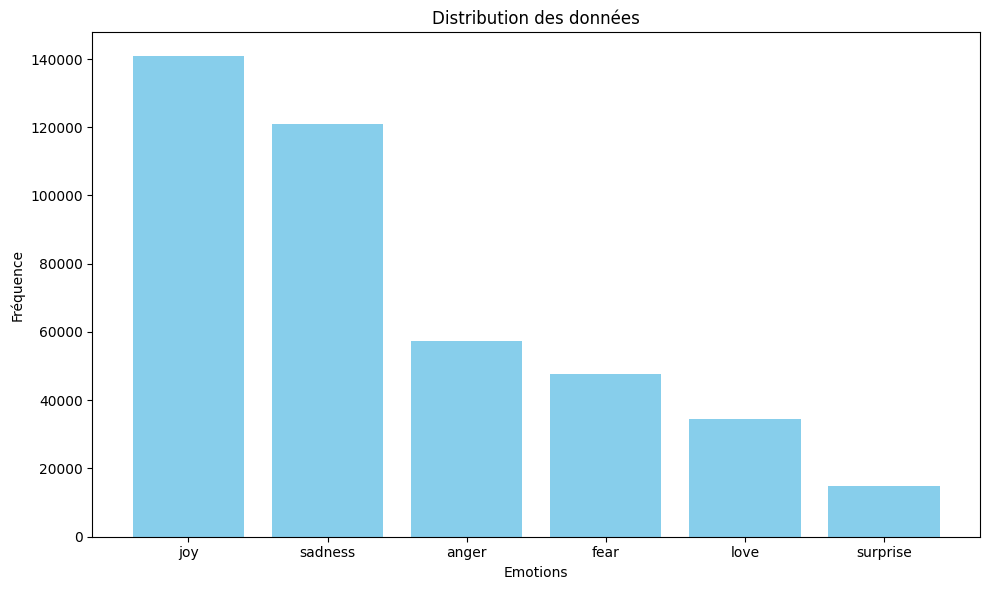

In [41]:
# Histogramme de la distribution des données
emotions = list(emotions_count.keys())
frequencies = list(emotions_count.values())

plt.figure(figsize=(10, 6))
plt.bar(emotions, frequencies, color='skyblue')

plt.xlabel('Emotions')
plt.ylabel('Fréquence')
plt.title('Distribution des données')
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('distribution_donnees_carer.png')
plt.show()

In [42]:
# Colonne length correspondant au nombre de mots de la colonne text
df['length'] = df['text'].str.split().apply(len)

In [46]:
df.sample(2)

,text,emotions,length
119138,ive been feeling kinda gloomy since i read s post about reservations,sadness,12
71048,i have hurt so much and been told to stop so much that i suppose it all leaked into my brain and now i feel guilty when i hurt,sadness,29


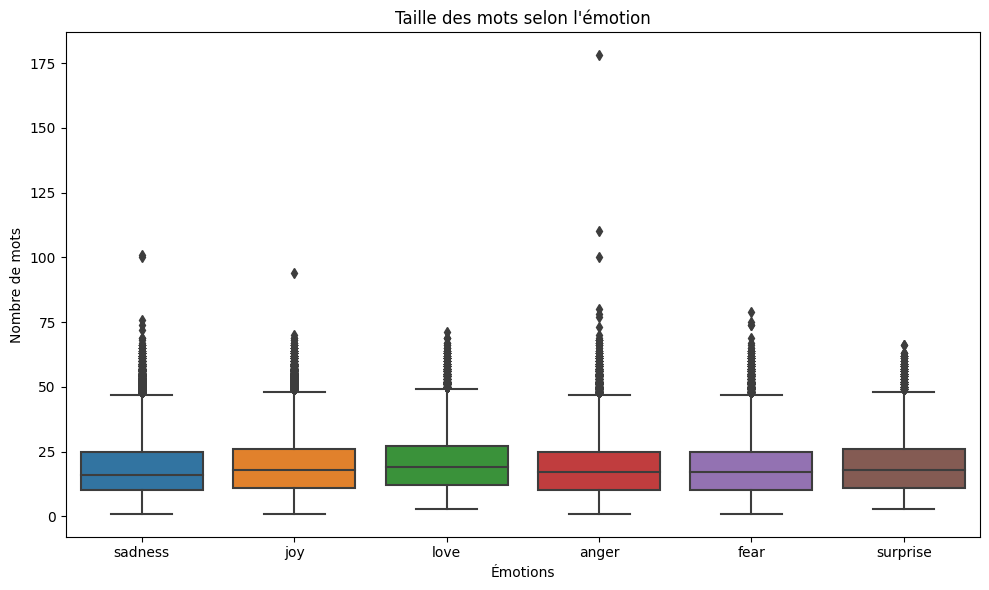

In [51]:
# Boxplots du nombre de mots par phrase selon l'émotion
plt.figure(figsize=(10, 6))

sns.boxplot(x='emotions', y='length', data=df)
plt.title('Taille des mots selon l\'émotion')
plt.xlabel('Émotions')
plt.ylabel('Nombre de mots')

plt.tight_layout()
plt.savefig('n_mots_par_emotions_carer.png')
plt.show()

# Préparation des données
* Suppression des "stop words" (mots fréquemment utilisés qui n'ont pas de signification forte pour la prédiction)
* Retirer les caractères spéciaux
* Passer le texte en minuscule

In [52]:
import re
import nltk
from nltk.corpus import stopwords

import random

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [54]:
# Retire les caractères spéciaux de la chaîne text
def remove_special_chars(text):
    return re.sub(r"[^a-zA-Z0-9]", " ", text)

In [55]:
# Passe la casse du texte en minuscule
def to_lowercase(text):
    return text.lower()

In [56]:
# Retire les 'stop words'
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

## Exemples de phrases transformées

In [78]:
n_examples = 3

sample_sentences = df['text'].sample(n=n_examples, random_state=42).tolist()

for sentence in sample_sentences:
    print(sentence)

    clean_sentence = remove_special_chars(sentence)
    clean_sentence = to_lowercase(clean_sentence)
    clean_sentence = remove_stop_words(clean_sentence)

    print("\t→ ", clean_sentence)
    print("\n")

i dont agree with him i do feel hes sincere and acting in good faith and with great personal honesty
	→  dont agree feel hes sincere acting good faith great personal honesty


i was feeling shitty and didnt bike in today which is shitty
	→  feeling shitty didnt bike today shitty


i am sort of numb a feeling of powerlessness all the care we took to protect the chickens from predators is not a guarantee that they will be safe
	→  sort numb feeling powerlessness care took protect chickens predators guarantee safe




## Application des fonctions à l'ensemble du jeu de données

In [79]:
df['text'] = df['text'].apply(lambda x : remove_special_chars(x))
df['text'] = df['text'].apply(lambda x : to_lowercase(x))
df['text'] = df['text'].apply(lambda x : remove_stop_words(x))

In [80]:
df.sample(2)

,text,emotions,length
46154,understand feelings feeling impatient next date also,anger,14
125139,woke feeling quite superior others drive around san jose,joy,16


## Visualisation de la taille des phrases après traitement

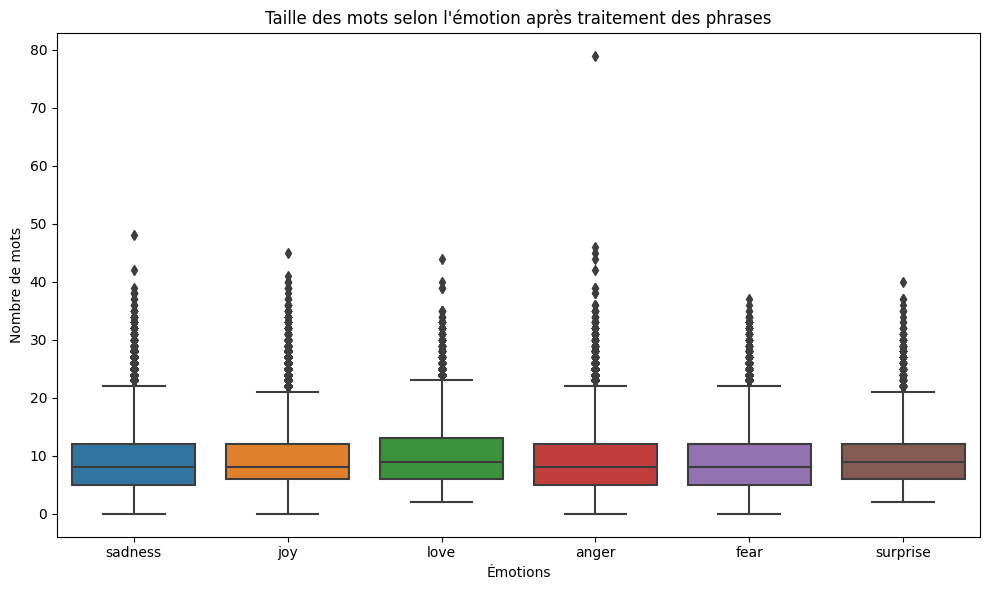

In [81]:
df['length_cleaned'] = df['text'].str.split().apply(len)

# Boxplots du nombre de mots par phrase selon l'émotion
plt.figure(figsize=(10, 6))

sns.boxplot(x='emotions', y='length_cleaned', data=df)
plt.title('Taille des mots selon l\'émotion après traitement des phrases')
plt.xlabel('Émotions')
plt.ylabel('Nombre de mots')

plt.tight_layout()
plt.savefig('n_mots_par_emotions_carer_nettoyes.png')
plt.show()

# Traitement des données
* ***Tokenization*** : Segmentation des phrases en séquences de mots (jetons/*tokens*)
* Transformation des mots en entier selon la taille du vocabulaire
D'après les analyses précédentes, on définit la taille du vocabulaire à 10 000 mots et la taille maximale d'une phrase à 25 mots.

In [82]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [83]:
# Taille maximale du vocabulaire
max_words = 10000
# Taille maximale d'une phrase
max_length = 25

In [84]:
# Nombre de mots uniques dans le jeu de données
words = ' '.join(df['text']).split()
unique_words_count = len(set(words))

print('Nombre de mots uniques : ', unique_words_count)

Nombre de mots uniques :  75150


In [85]:
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [86]:
rand = random.randint(0, len(sequences)-1)
random_sequence = sequences[rand]

# Exemple de phrase après transformation en séquences
print(random_sequence)
print(df.iloc[rand]['text'])

[1, 3, 5, 285, 11, 12]
feel like really cool would want


In [87]:
# Transformation des phrases en tenseur de taille 25 (max_length, la taille maximale définie d'une phrase)
padded_sequences = pad_sequences(sequences=sequences, maxlen=max_length)
# padded_sequences = pad_sequences(sequences=sequences, maxlen=max_length, padding='post', truncating='post')

print('Séquence transformée avec max_length=' + str(max_length))
print(padded_sequences[rand])

Séquence transformée avec max_length=25
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   1   3   5 285  11  12]


# Entraînement du modèle

In [115]:
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Flatten, Dropout

from keras.callbacks import ModelCheckpoint

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [114]:
# Encodage des labels en entiers
le = LabelEncoder()
encoded_labels = le.fit_transform(df['emotions'])

# Vectorisation des labels
y = to_categorical(encoded_labels)

NB_CLASSES = y.shape[1]

In [118]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

In [116]:
# Instauration d'un checkpoint pour la meilleure valeur de val_loss
checkpoint = ModelCheckpoint(
    filepath='ck_model_text.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min' # minimisation de la loss sur l'ensemble de validation
)

In [117]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_length))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(NB_CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            640000    
                                                                 
 lstm (LSTM)                 (None, 25, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 686694 (2.62 MB)
Trainable params: 686694 (2.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [119]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=[checkpoint])

Epoch 1/10
9363/9363 [==============================] - ETA: 0s - loss: 0.3540 - accuracy: 0.8493
Epoch 1: val_loss improved from inf to 0.10811, saving model to ck_model_text.keras
9363/9363 [==============================] - 392s 41ms/step - loss: 0.3540 - accuracy: 0.8493 - val_loss: 0.1081 - val_accuracy: 0.9351
Epoch 2/10
9362/9363 [============================>.] - ETA: 0s - loss: 0.1042 - accuracy: 0.9374
Epoch 2: val_loss improved from 0.10811 to 0.10151, saving model to ck_model_text.keras
9363/9363 [==============================] - 373s 40ms/step - loss: 0.1042 - accuracy: 0.9374 - val_loss: 0.1015 - val_accuracy: 0.9363
Epoch 3/10
9362/9363 [============================>.] - ETA: 0s - loss: 0.0991 - accuracy: 0.9401
Epoch 3: val_loss improved from 0.10151 to 0.09684, saving model to ck_model_text.keras
9363/9363 [==============================] - 372s 40ms/step - loss: 0.0991 - accuracy: 0.9401 - val_loss: 0.0968 - val_accuracy: 0.9388
Epoch 4/10
9363/9363 [================

# Résultats et interprétations

In [130]:
from sklearn.metrics import confusion_matrix

In [120]:
# Récupération des métriques sur l'ensemble d'entraînement et de validation
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(history.epoch) + 1)

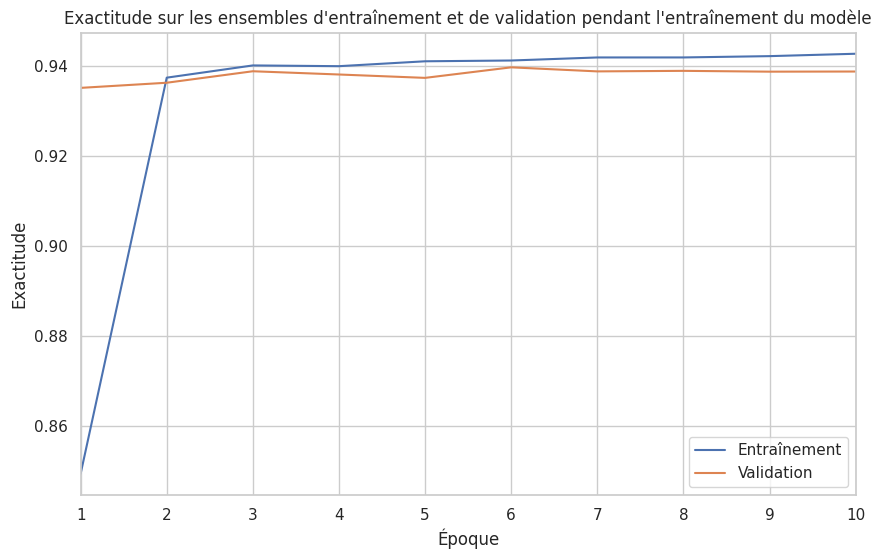

In [128]:
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))

plt.plot(epochs, acc, label='Entraînement')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Exactitude sur les ensembles d\'entraînement et de validation pendant l\'entraînement du modèle')
plt.xlabel('Époque')
plt.ylabel('Exactitude')
plt.legend()
plt.xlim(1, 10)
plt.savefig('accuracy_modele_texte_carer.png')
plt.show()

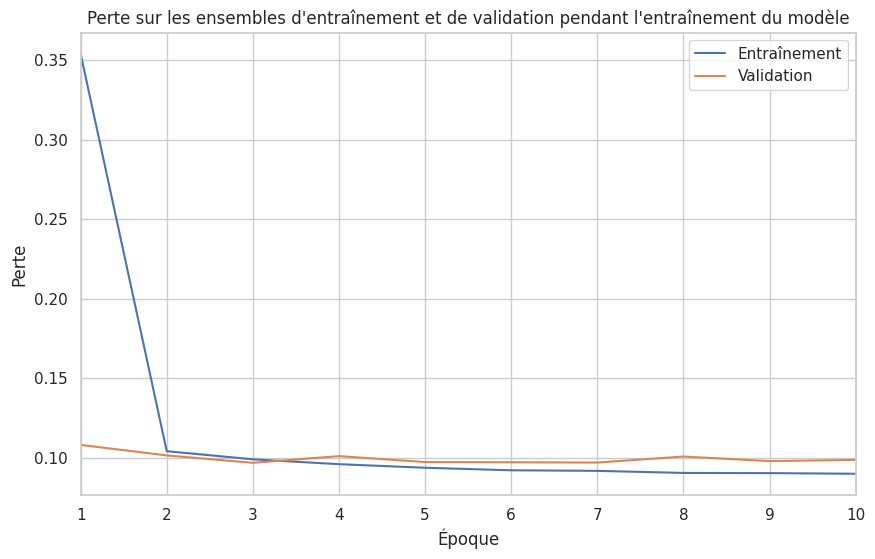

In [124]:
plt.figure(figsize=(10, 6))

plt.plot(epochs, loss, label='Entraînement')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Perte sur les ensembles d\'entraînement et de validation pendant l\'entraînement du modèle')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.xlim(1, 10)
plt.savefig('loss_modele_texte_carer.png')
plt.show()

In [129]:
# Évaluation du modèle
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32)

print("Perte avec l'ensemble de test : ", test_loss)
print("Exactitude avec l'ensemble de test : ", test_acc)

2601/2601 [==============================] - 17s 7ms/step - loss: 0.0980 - accuracy: 0.9400
Perte avec l'ensemble de test :  0.09802965819835663
Exactitude avec l'ensemble de test :  0.939981997013092


In [135]:
# Prédictions faites par le modèle sur l'ensemble de test
predictions = model.predict(X_test)
# Récupération des indices de la valeur maximale dans le vecteur de la prédiction du modèle
predicted_classes = np.argmax(predictions, axis=1)

# Nom des classes pour légender les lignes/colonnes de la matrice
classes_name = list(emotions_count.keys())

2601/2601 [==============================] - 16s 6ms/step


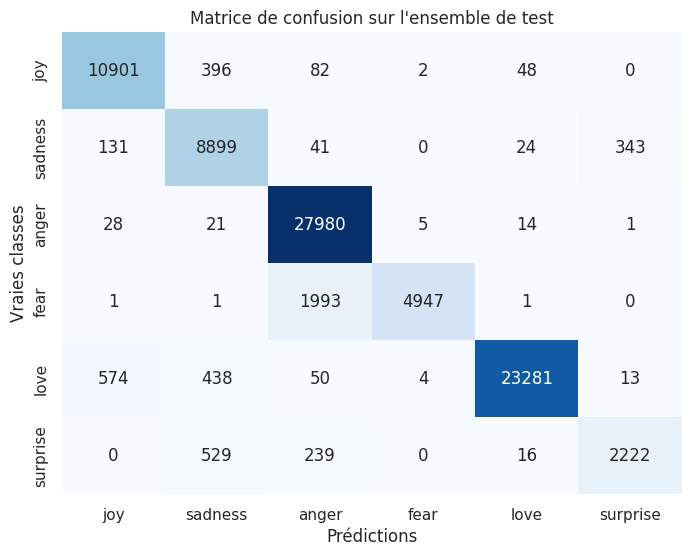

In [138]:
# Matrice de confusion
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes_name, yticklabels=classes_name)
plt.xlabel('Prédictions')
plt.ylabel('Vraies classes')
plt.title('Matrice de confusion sur l\'ensemble de test')

plt.savefig('matrice_confusion_carer.png')
plt.show()

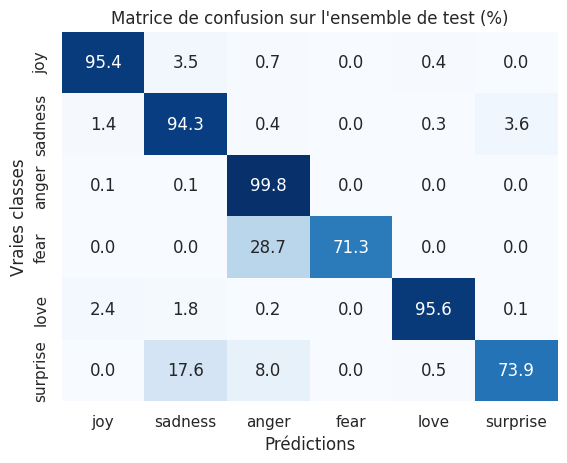

In [140]:
# Matrice de confusion en pourcentage
conf_matrix_sum = np.sum(conf_matrix, axis=1, keepdims=True)
conf_matrix_percent = conf_matrix / conf_matrix_sum.astype(float) * 100

sns.heatmap(conf_matrix_percent, annot=True, fmt='.1f', cmap='Blues', cbar=False,
            xticklabels=classes_name, yticklabels=classes_name)

plt.title('Matrice de confusion sur l\'ensemble de test (%)')
plt.xlabel('Prédictions')
plt.ylabel('Vraies classes')

plt.savefig('matrice_confusion_pourcent_carer.png')
plt.show()

['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']
